Hello! Let's take a swing at timeseries prediction. The goal is to use the hydrometer and thermometer data collected from my basement to predict a week in advance.
We'll validate and test by cutting off small intervals at the end.


We COULD just smooth a rolling average and use a line of regression to predict when the basement temp becomes unacceptable, but then we loose a lot of character from the data. It is more useful to see how big these hot windows are to see whether it's worth the work of moving the wine.

Interesting Note: I originally tried this with 15 minute intervals, but it seems to overwhelm the methods. In parameter diagnostics, I was getting AIC of tens of thousands - not good. I have a lot to learn about time series, but it interesting to see how too much data can overwhelm processes.

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
import itertools
import statsmodels.api as sm

df = pd.read_csv('Govee_12hr.csv')
df = df.drop('Relative_Humidity', axis=1)
df.head()

,Timestamp for sample frequency every 12 Hrs min,Temperature_Fahrenheit
0,2021-02-23 09:54:00,52.88
1,2021-02-23 21:54:00,54.50
2,2021-02-24 09:54:00,54.68
3,2021-02-24 21:54:00,56.30
4,2021-02-25 09:54:00,56.84


In [14]:
df.columns = ['time','temp']
df.head()

,time,temp
0,2021-02-23 09:54:00,52.88
1,2021-02-23 21:54:00,54.50
2,2021-02-24 09:54:00,54.68
3,2021-02-24 21:54:00,56.30
4,2021-02-25 09:54:00,56.84


In [15]:
df.describe()

,temp
count,133.000000
mean,62.943759
std,3.360886
min,52.880000
25%,60.260000
50%,63.680000
75%,65.300000
max,71.240000


In [16]:
df['temp_SMA_1wk'] = df.temp.rolling(14, min_periods=1, center=True).mean()

Text(0, 0.5, 'Temperature [°F]')

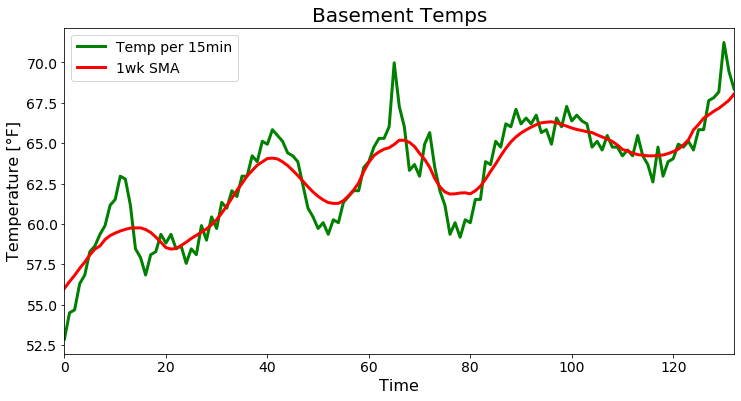

In [17]:
# colors for the line plot
colors = ['green', 'red']

# line plot - the yearly average air temperature in Barcelona
df.plot(color=colors, linewidth=3, figsize=(12,6))

# modify ticks size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels =['Temp per 15min', '1wk SMA'], fontsize=14)

# title and labels
plt.title('Basement Temps', fontsize=20)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Temperature [°F]', fontsize=16)

In [18]:
p = q = d = range(0,2)
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0],x[1],x[2],25) for x in list(itertools.product(p,d,q))]

print('{} x {}'.format(pdq[2],seasonal_pdq[2]))

(0, 1, 0) x (0, 1, 0, 25)


In [19]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
            model = sm.tsa.statespace.SARIMAX(df[:5000]['temp'],
                                              order=param,
                                              seasonal_order=param_seasonal,
                                              enforce_invertibility=False,
                                              enforce_stationarity=False)
            results = model.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            

ARIMA(0, 0, 0)x(0, 0, 0, 25)12 - AIC:1470.8204059242003
ARIMA(0, 0, 0)x(0, 0, 1, 25)12 - AIC:1110.0297440581746
ARIMA(0, 0, 0)x(0, 1, 0, 25)12 - AIC:548.1137903964401
ARIMA(0, 0, 0)x(0, 1, 1, 25)12 - AIC:392.55324638154895
ARIMA(0, 0, 0)x(1, 0, 0, 25)12 - AIC:528.1093583125272
ARIMA(0, 0, 0)x(1, 0, 1, 25)12 - AIC:517.9147162549964
ARIMA(0, 0, 0)x(1, 1, 0, 25)12 - AIC:396.0740049162341
ARIMA(0, 0, 0)x(1, 1, 1, 25)12 - AIC:393.802920061536
ARIMA(0, 0, 1)x(0, 0, 0, 25)12 - AIC:1293.5654647577076
ARIMA(0, 0, 1)x(0, 0, 1, 25)12 - AIC:974.2787343656145
ARIMA(0, 0, 1)x(0, 1, 0, 25)12 - AIC:494.83903847809194
ARIMA(0, 0, 1)x(0, 1, 1, 25)12 - AIC:362.19910894580136
ARIMA(0, 0, 1)x(1, 0, 0, 25)12 - AIC:487.5707784755902
ARIMA(0, 0, 1)x(1, 0, 1, 25)12 - AIC:456.90042445649823
ARIMA(0, 0, 1)x(1, 1, 0, 25)12 - AIC:369.87908665646773
ARIMA(0, 0, 1)x(1, 1, 1, 25)12 - AIC:362.89580597414425
ARIMA(0, 1, 0)x(0, 0, 0, 25)12 - AIC:405.58549214038646
ARIMA(0, 1, 0)x(0, 0, 1, 25)12 - AIC:331.55678097681727


/Users/macdelay/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 0, 1, 25)12 - AIC:338.1878195062025
ARIMA(1, 0, 0)x(0, 1, 0, 25)12 - AIC:417.4595492395719
ARIMA(1, 0, 0)x(0, 1, 1, 25)12 - AIC:284.33860421516806


/Users/macdelay/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(1, 0, 0, 25)12 - AIC:333.16940104029504


/Users/macdelay/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 25)12 - AIC:335.7003470720858
ARIMA(1, 0, 0)x(1, 1, 0, 25)12 - AIC:288.815708318559
ARIMA(1, 0, 0)x(1, 1, 1, 25)12 - AIC:283.48231447706104
ARIMA(1, 0, 1)x(0, 0, 0, 25)12 - AIC:407.25759123552143


/Users/macdelay/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(0, 0, 1, 25)12 - AIC:335.2532040031244
ARIMA(1, 0, 1)x(0, 1, 0, 25)12 - AIC:409.25186282925796
ARIMA(1, 0, 1)x(0, 1, 1, 25)12 - AIC:282.51845324502654
ARIMA(1, 0, 1)x(1, 0, 0, 25)12 - AIC:334.56429127195213


/Users/macdelay/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 0, 1, 25)12 - AIC:338.88332117969304
ARIMA(1, 0, 1)x(1, 1, 0, 25)12 - AIC:289.2747522809771
ARIMA(1, 0, 1)x(1, 1, 1, 25)12 - AIC:282.88629104452986
ARIMA(1, 1, 0)x(0, 0, 0, 25)12 - AIC:405.5619827719523
ARIMA(1, 1, 0)x(0, 0, 1, 25)12 - AIC:331.12208921343375
ARIMA(1, 1, 0)x(0, 1, 0, 25)12 - AIC:404.2214218845944
ARIMA(1, 1, 0)x(0, 1, 1, 25)12 - AIC:281.82817780663964
ARIMA(1, 1, 0)x(1, 0, 0, 25)12 - AIC:330.8939054079101
ARIMA(1, 1, 0)x(1, 0, 1, 25)12 - AIC:332.88736845217085
ARIMA(1, 1, 0)x(1, 1, 0, 25)12 - AIC:287.63421976276345
ARIMA(1, 1, 0)x(1, 1, 1, 25)12 - AIC:282.97131436789
ARIMA(1, 1, 1)x(0, 0, 0, 25)12 - AIC:369.37966287401827
ARIMA(1, 1, 1)x(0, 0, 1, 25)12 - AIC:301.78685443053104
ARIMA(1, 1, 1)x(0, 1, 0, 25)12 - AIC:354.71224470553193
ARIMA(1, 1, 1)x(0, 1, 1, 25)12 - AIC:259.48705776367603
ARIMA(1, 1, 1)x(1, 0, 0, 25)12 - AIC:304.9149684552226
ARIMA(1, 1, 1)x(1, 0, 1, 25)12 - AIC:303.5122924822584
ARIMA(1, 1, 1)x(1, 1, 0, 25)12 - AIC:276.3884249728623
AR

We pick the highest-performing set of parameters. A two week period (delta-x = 25) is constant because we estimated seasonality to be the approx distance between peaks in our data.

In [20]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(df[:5000]['temp'],
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 25),
                               enforced_stationary=False,
                               enforce_invertibility = True)
results=model.fit()

/Users/macdelay/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/macdelay/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/macdelay/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


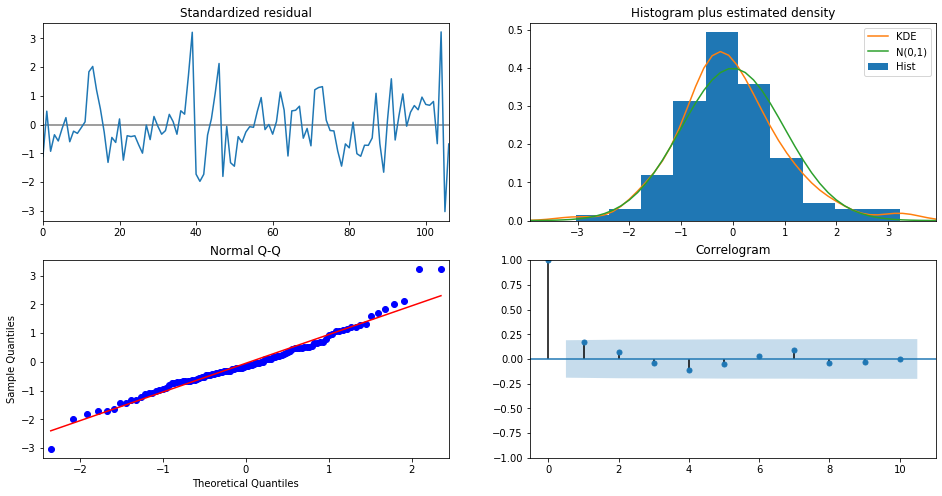

In [21]:
results.plot_diagnostics(figsize=(16,8))
plt.show()

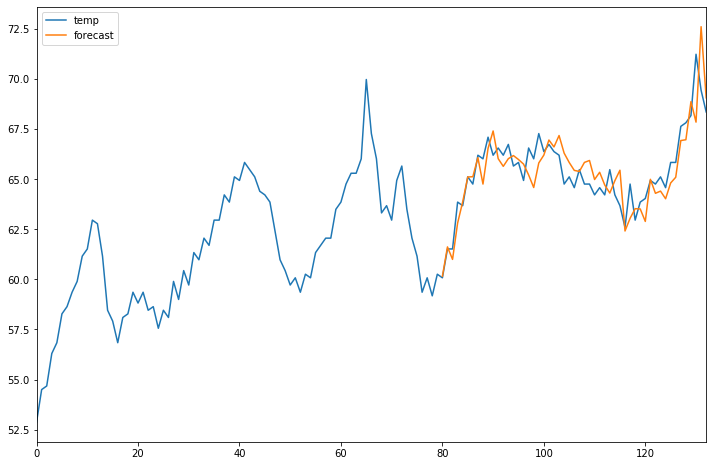

In [22]:
df['forecast']=results.predict(start=80,end=132,dynamic=False)
df[['temp','forecast']].plot(figsize=(12,8))

In [23]:
df.tail()

,time,temp,temp_SMA_1wk,forecast
128,2021-04-28 10:54:00,67.82,66.980000,66.972737
129,2021-04-28 22:54:00,68.18,67.165455,68.875104
130,2021-04-29 10:54:00,71.24,67.406000,67.851528
131,2021-04-29 22:54:00,69.44,67.660000,72.616446
132,2021-04-30 10:54:00,68.36,68.045000,69.065305


In [24]:
forecast = pd.DataFrame(results.predict(start=0, end= 200, dynamic = False))

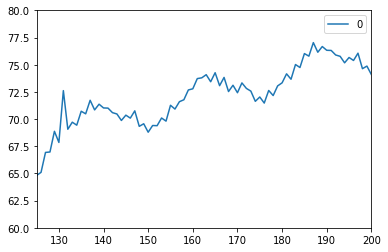

In [25]:
forecast.plot(xlim=(125,200),ylim=(60,80))

We see above that after ~175, the temperature escapes 72 degrees. At this point, there is no sense in keeping the wine in the basement over a typical room in the house as we don't want the wine to 'cook'. The statistical recommendation is to consider moving the wine in about 21 days (or at least monitor the temperature cautiously around then).